# Categorical prediction for houses in Iowa --> Expensive vs. not expensive

The task: create a model that if a house is "expensive" oder "not expensive" based on its characteristics.  
Basis is a datase with 1460 houses and 79 describing features.  
Explanation of features can be found in the txt file data_description.



This is the 1st part of the tas used to explore the dataframe.  


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

from sklearn import set_config
set_config(transform_output="pandas")
pd.set_option('display.max_rows', 100)

## Prepare the dataset

In [10]:
houses_raw = pd.read_csv("data/housing-classification-iter6.csv")

In [11]:
houses_df = houses_raw.copy().drop_duplicates()

In [12]:
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   TotalBsmtSF    1460 non-null   int64  
 3   BedroomAbvGr   1460 non-null   int64  
 4   Fireplaces     1460 non-null   int64  
 5   PoolArea       1460 non-null   int64  
 6   GarageCars     1460 non-null   int64  
 7   WoodDeckSF     1460 non-null   int64  
 8   ScreenPorch    1460 non-null   int64  
 9   Expensive      1460 non-null   int64  
 10  MSZoning       1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Heating        1460 non-null   object 
 13  Street         1460 non-null   object 
 14  CentralAir     1460 non-null   object 
 15  Foundation     1460 non-null   object 
 16  ExterQual      1460 non-null   object 
 17  ExterCond      1460 non-null   object 
 18  BsmtQual

## Split the dataset into train and test data

In [14]:
X = houses_df.copy()
X = X.drop(columns=["Id"])

In [15]:
y = houses_df.pop("Expensive")

In [16]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 12120)

## Explore X train

In [18]:
X_train["Expensive"] = y_train

In [19]:
X_train.describe()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,...,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageArea,OpenPorchSF,EnclosedPorch,3SsnPorch,MiscVal,MoSold,YrSold
count,1168.000000,968.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,...,1168.000000,1168.000000,1102.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,10540.261986,70.163223,1068.057363,2.882705,0.619863,3.448630,1.772260,96.133562,15.701199,0.151541,...,1.048801,6.518836,1978.326679,472.206336,46.750856,21.427226,2.886986,36.321918,6.271404,2007.815068
std,10012.215187,23.796366,449.353180,0.816985,0.648787,44.896939,0.752842,127.261429,56.783604,0.358729,...,0.223354,1.611225,24.869877,212.602975,67.145652,61.386995,27.427541,316.483592,2.691025,1.333779
min,1300.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,7639.000000,60.000000,795.750000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,5.000000,1961.250000,334.500000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,9475.000000,70.000000,992.000000,3.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,1.000000,6.000000,1979.500000,480.000000,25.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,11588.000000,80.000000,1309.250000,3.000000,1.000000,0.000000,2.000000,168.250000,0.000000,0.000000,...,1.000000,7.000000,2002.000000,576.000000,66.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,215245.000000,313.000000,6110.000000,8.000000,3.000000,738.000000,4.000000,857.000000,480.000000,1.000000,...,3.000000,14.000000,2010.000000,1418.000000,547.000000,552.000000,508.000000,8300.000000,12.000000,2010.000000


### Cleaning

In [21]:
num_columns_lst = (X_train.select_dtypes(include="number").columns)


outlier_low_list =[]
outlier_high_list =[]

for key in num_columns_lst:
    q1 = X_train[key].quantile(0.25)
    q3 =  X_train[key].quantile(0.75)
    q10 =  X_train[key].quantile(0.1)
    q90 = X_train[key].quantile(0.9)
    
    outlier_low = (q1 - 1.5*(q3-q1))
    idx_low = X_train.loc[X_train[key] < outlier_low,].index.to_list()
    outlier_low_list.append(idx_low)
    
    if q90 > 1:
        outlier_high = (q90 + 1.5*(q90-q10))
        idx_high = X_train.loc[X_train[key]> outlier_high,].index.to_list()
        outlier_high_list.append(idx_high)

outlier_low_list = list(set([item for sublist in outlier_low_list for item in sublist]))
outlier_high_list = list(set([item for sublist in outlier_high_list for item in sublist]))


In [22]:
X_train = X_train.loc[~(X_train.index.isin(outlier_high_list)),:]
X_train = X_train.loc[~(X_train.index.isin(outlier_low_list)),:]

 ### **subsegements of columns on the same aspects**  
 find correlations and uncessary columns

In [24]:
def correlation(house_col):
    columns_lst = house_col.columns.to_list()
    corr_dict = {column:[] for column in columns_lst}

    for key in corr_dict: 
        for column in columns_lst:
            corr_dict[key].append(house_col[key].corr(house_col[column]))
    corr_df = pd.DataFrame(corr_dict, 
                           index = corr_dict.keys()
                          )
    return corr_df

In [25]:
# Rooms 
rooms = X_train.loc[:,["BedroomAbvGr","FullBath", "HalfBath", "KitchenAbvGr","TotRmsAbvGrd","Expensive"]]

In [26]:
rooms.describe()

,BedroomAbvGr,FullBath,HalfBath,KitchenAbvGr,TotRmsAbvGrd,Expensive
count,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,2.885536,1.570239,0.385016,1.039542,6.500520,0.152966
std,0.753747,0.523916,0.507798,0.200253,1.507706,0.360142
min,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000
25%,2.000000,1.000000,0.000000,1.000000,5.000000,0.000000
50%,3.000000,2.000000,0.000000,1.000000,6.000000,0.000000
75%,3.000000,2.000000,1.000000,1.000000,7.000000,0.000000
max,6.000000,3.000000,2.000000,3.000000,12.000000,1.000000


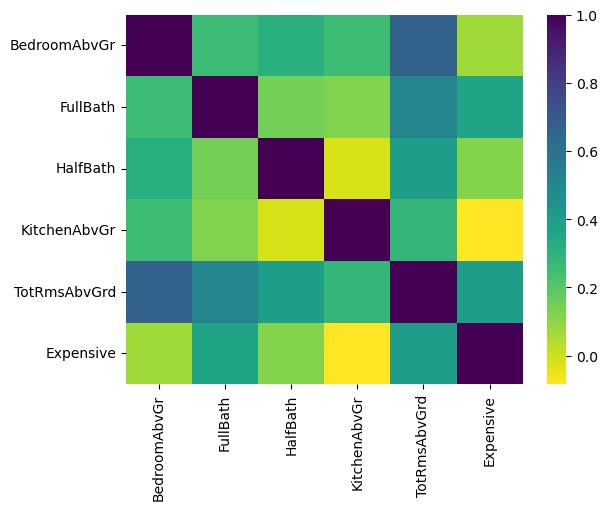

In [27]:
corr_df = correlation(rooms)

sns.heatmap(corr_df,
            cmap="viridis_r",
           );

In [28]:
# Size
size = X_train.loc[:,["LotArea" ,
            "LotFrontage",
            "ScreenPorch",
            "OpenPorchSF",
            "EnclosedPorch",
            "3SsnPorch"    , # Three season porch area in square feet
            "GrLivArea",     # Above grade (ground) living area square feet
            "1stFlrSF"  ,    
            "2ndFlrSF",
            "Expensive"]]

In [29]:
size.describe()

,LotArea,LotFrontage,ScreenPorch,OpenPorchSF,EnclosedPorch,3SsnPorch,GrLivArea,1stFlrSF,2ndFlrSF,Expensive
count,961.000000,797.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,9764.331946,71.134253,14.225806,46.642040,18.852237,3.321540,1494.214360,1154.497399,335.610822,0.152966
std,3587.391922,19.663841,52.775369,59.319868,53.591676,29.661838,457.645382,353.705519,419.788499,0.360142
min,1974.000000,30.000000,0.000000,0.000000,0.000000,0.000000,438.000000,438.000000,0.000000,0.000000
25%,7758.000000,60.000000,0.000000,0.000000,0.000000,0.000000,1144.000000,884.000000,0.000000,0.000000
50%,9452.000000,70.000000,0.000000,29.000000,0.000000,0.000000,1470.000000,1085.000000,0.000000,0.000000
75%,11428.000000,80.000000,0.000000,70.000000,0.000000,0.000000,1766.000000,1378.000000,728.000000,0.000000
max,26178.000000,168.000000,396.000000,319.000000,275.000000,508.000000,3447.000000,2633.000000,1523.000000,1.000000


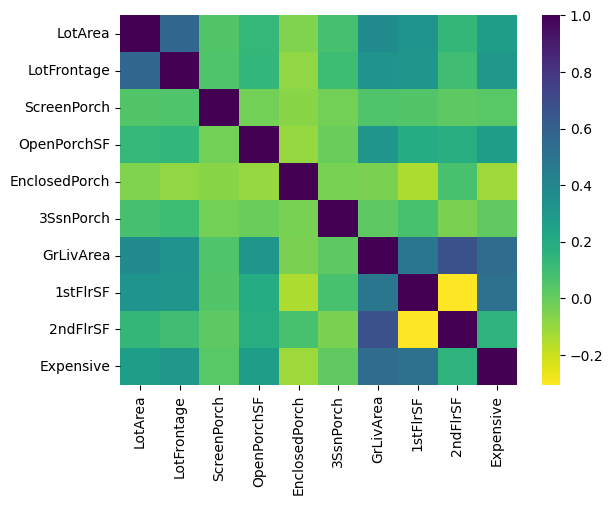

In [30]:
corr_size_df = correlation(size)

sns.heatmap(corr_size_df,
            cmap="viridis_r",
           );

In [31]:
# Area and property
X_train.loc[:,["MSZoning", #general zoning classification of the sale
            "Condition1", #Proximity to various conditions
            "Condition2"  , # Proximity to various conditions (if more than one is present)
            "Street", #road access to property
            "Alley", #alley access to property
            "MSSubClass", #type of dwelling involved in the sale
           "BldgType",
            "HouseStyle",
            "LotShape", # General shape of property
           "LandContour", #Flatness of the property
            "LotConfig"    ,#Lot configuration
            "LandSlope" , #Slope of property
            "Neighborhood" #Physical locations within Ames city limits
           ]]

,MSZoning,Condition1,Condition2,Street,Alley,MSSubClass,BldgType,HouseStyle,LotShape,LandContour,LotConfig,LandSlope,Neighborhood
572,RL,Norm,Norm,Pave,NaN,60,1Fam,2Story,IR1,HLS,Corner,Gtl,Timber
290,RL,Norm,Norm,Pave,NaN,60,1Fam,2Story,Reg,Lvl,Inside,Gtl,CollgCr
660,RL,Norm,Norm,Pave,NaN,60,1Fam,2Story,Reg,Lvl,CulDSac,Gtl,NWAmes
993,RL,Norm,Norm,Pave,NaN,60,1Fam,2Story,Reg,Lvl,Inside,Gtl,CollgCr
282,RL,Norm,Norm,Pave,NaN,120,Twnhs,1Story,Reg,Lvl,Inside,Gtl,NridgHt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,RL,RRAn,Norm,Pave,NaN,20,1Fam,1Story,IR2,Lvl,CulDSac,Gtl,Somerst
140,RL,Norm,Norm,Pave,NaN,20,1Fam,1Story,Reg,Lvl,FR2,Gtl,NAmes
466,RL,Norm,Norm,Pave,NaN,20,1Fam,1Story,Reg,Lvl,Inside,Gtl,NAmes
79,RM,Norm,Norm,Pave,Grvl,50,1Fam,2Story,Reg,Lvl,Corner,Gtl,OldTown


<Axes: xlabel='LandSlope', ylabel='Count'>

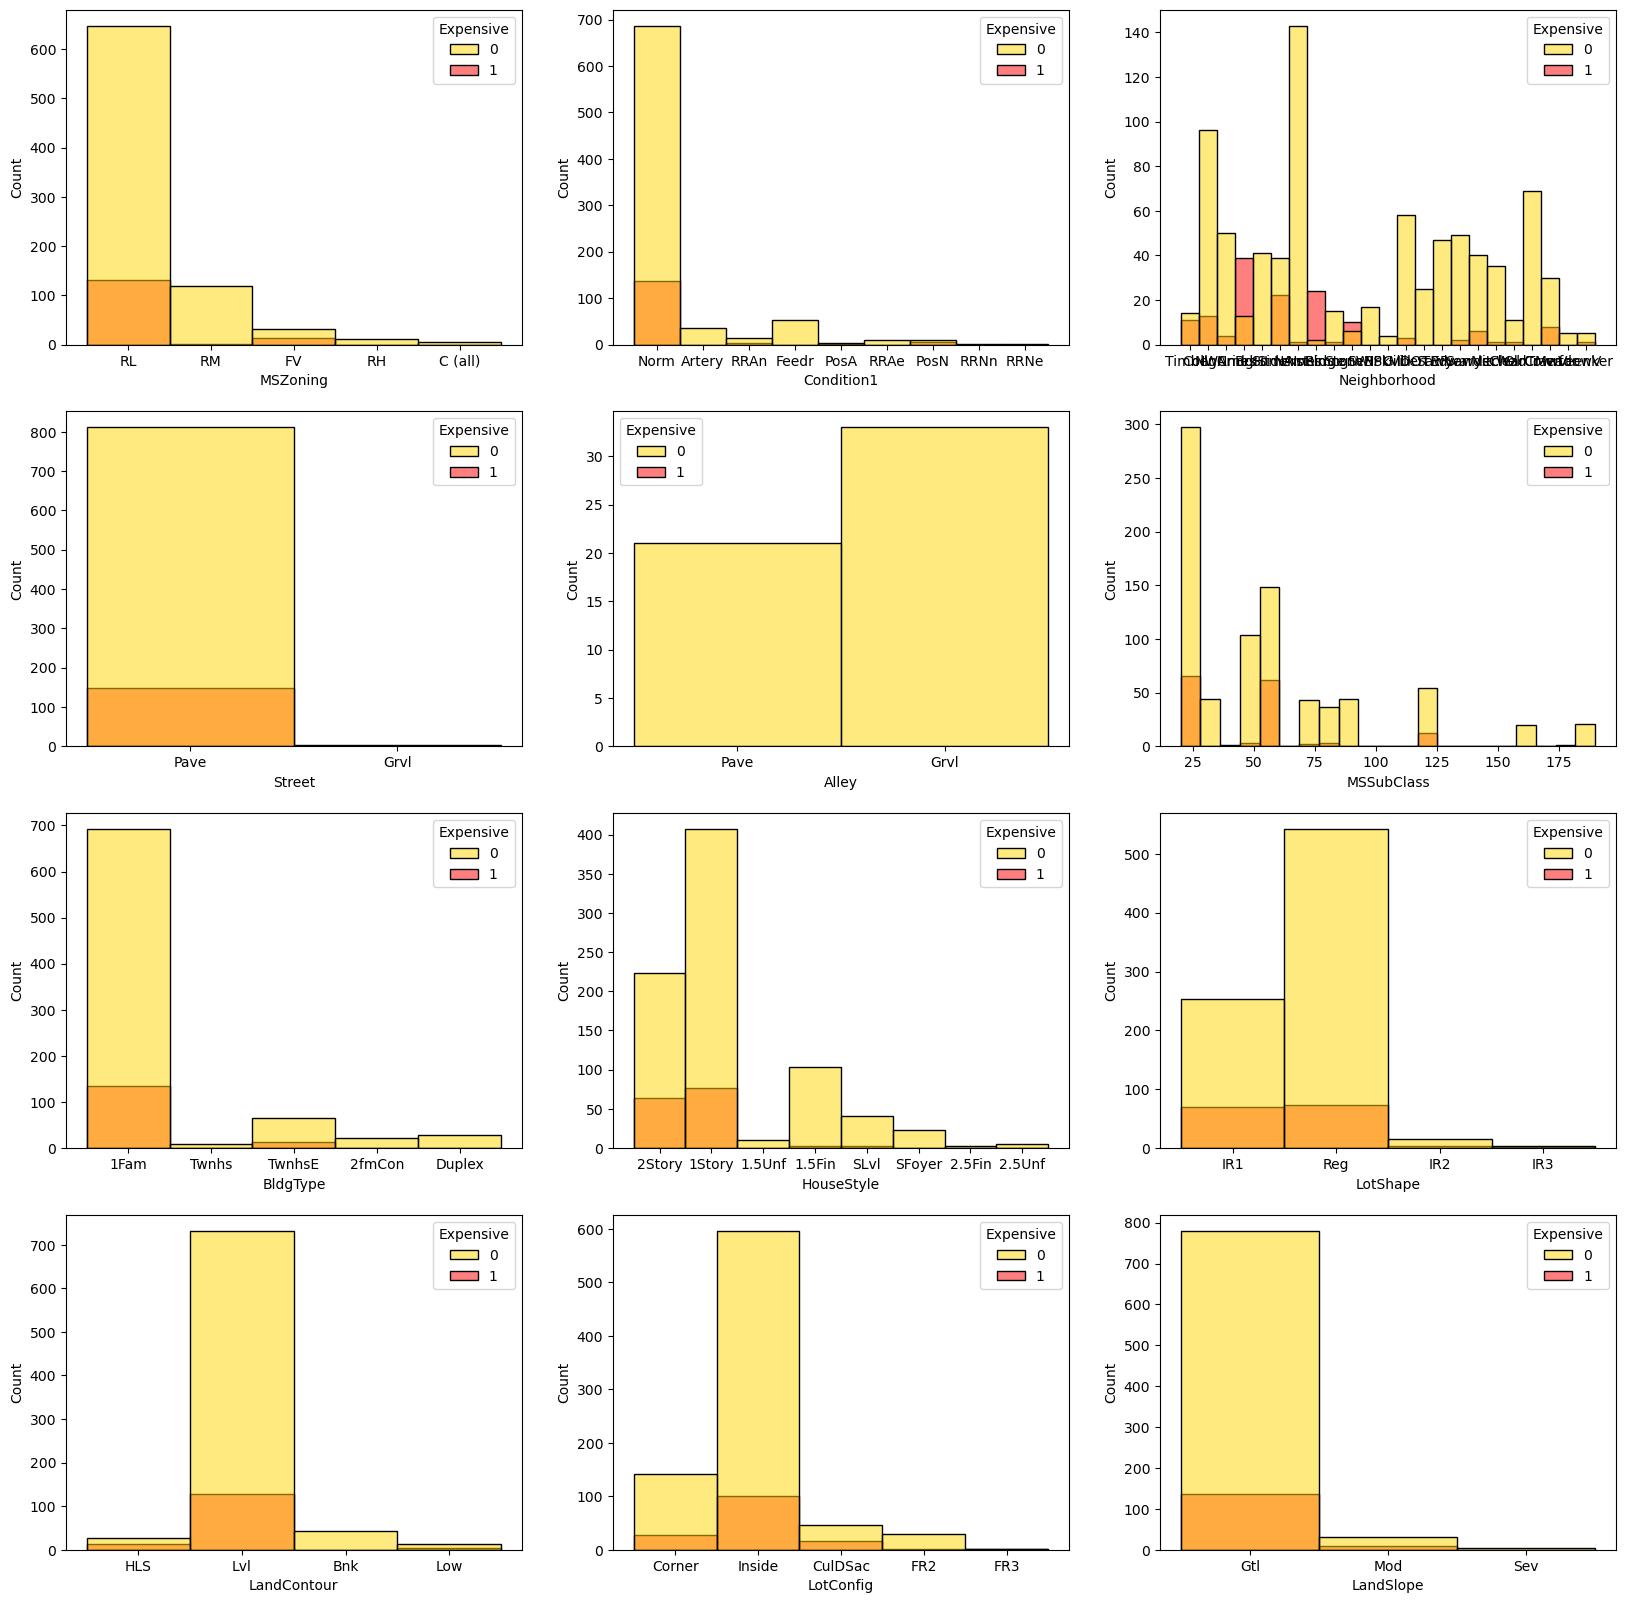

In [32]:
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8),(ax9,ax10,ax11)) = plt.subplots(nrows=4, ncols=3, sharex=False,
                                                            figsize=(20, 20))

sns.histplot(data = X_train, x = "MSZoning", hue="Expensive",palette=["gold","red"], ax=ax0)
sns.histplot(data = X_train, x = "Condition1",hue="Expensive",palette=["gold","red"], ax=ax1)
sns.histplot(data = X_train, x = "Neighborhood" , hue="Expensive",palette=["gold","red"], ax=ax2)

sns.histplot(data = X_train, x = "Street", hue="Expensive",palette=["gold","red"], ax=ax3)
sns.histplot(data = X_train, x = "Alley",hue="Expensive",palette=["gold","red"], ax=ax4)
sns.histplot(data = X_train, x = "MSSubClass",hue="Expensive",palette=["gold","red"], ax=ax5)

sns.histplot(data = X_train, x = "BldgType", hue="Expensive",palette=["gold","red"], ax=ax6)
sns.histplot(data = X_train, x = "HouseStyle" , hue="Expensive",palette=["gold","red"], ax=ax7)
sns.histplot(data = X_train, x = "LotShape", hue="Expensive",palette=["gold","red"], ax=ax8)

sns.histplot(data = X_train, x = "LandContour", hue="Expensive",palette=["gold","red"], ax=ax9)
sns.histplot(data = X_train, x = "LotConfig" , hue="Expensive",palette=["gold","red"], ax=ax10)
sns.histplot(data = X_train, x = "LandSlope", hue="Expensive",palette=["gold","red"], ax=ax11)


In [33]:
basement = X_train.loc[:,["TotalBsmtSF",
            "BsmtFinSF1", #Type 1 finished square feet
            "BsmtFinSF2",
            "BsmtUnfSF" ,
            "BsmtFullBath" ,
            "BsmtHalfBath",
            "Expensive"
           ]]

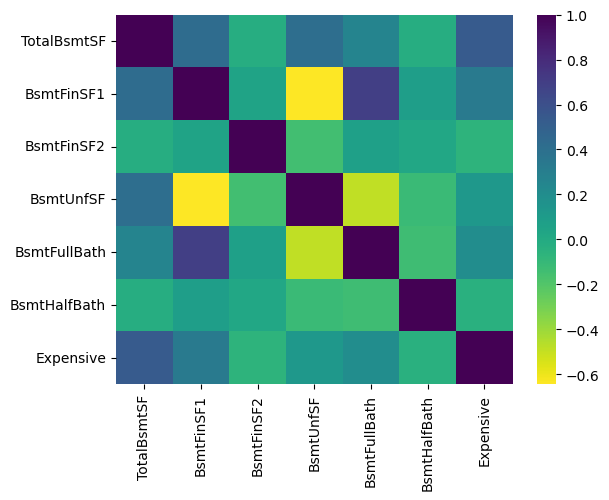

In [34]:
corr_bsmt_df = correlation(basement)

sns.heatmap(corr_bsmt_df,
            cmap="viridis_r",
           );

<Axes: xlabel='BsmtFullBath', ylabel='Count'>

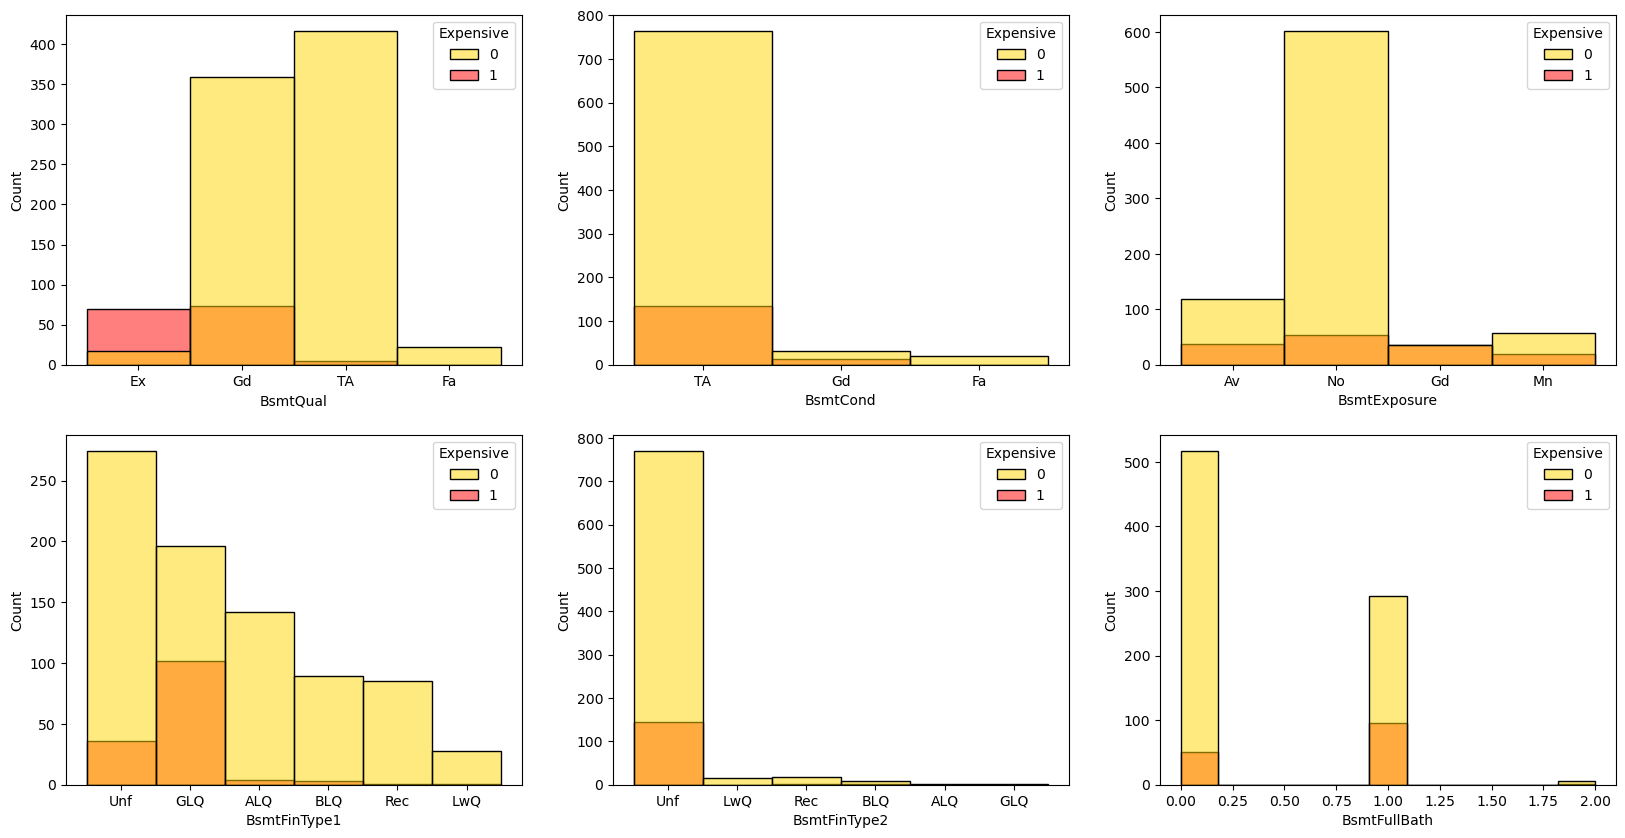

In [35]:
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5),) = plt.subplots(nrows=2, ncols=3, sharex=False,
                                                            figsize=(20, 10))

sns.histplot(data = X_train, x = "BsmtQual", hue="Expensive",palette=["gold","red"], ax=ax0)
sns.histplot(data = X_train, x = "BsmtCond",hue="Expensive",palette=["gold","red"], ax=ax1)
sns.histplot(data = X_train, x =  "BsmtExposure" , hue="Expensive",palette=["gold","red"], ax=ax2)

sns.histplot(data = X_train, x = "BsmtFinType1", hue="Expensive",palette=["gold","red"], ax=ax3)
sns.histplot(data = X_train, x = "BsmtFinType2",hue="Expensive",palette=["gold","red"], ax=ax4)
sns.histplot(data = X_train, x = "BsmtFullBath",hue="Expensive",palette=["gold","red"], ax=ax5)

In [36]:
# Extras 
extra = X_train.loc[:,["Fireplaces" , 
            "PoolArea"      ,
            "GarageCars"  ,
            "GarageYrBlt",
            "GarageArea"   ,
            "WoodDeckSF",     
            "MiscVal",
            "Expensive"
           ]]    #Miscellaneous feature not covered in other categories


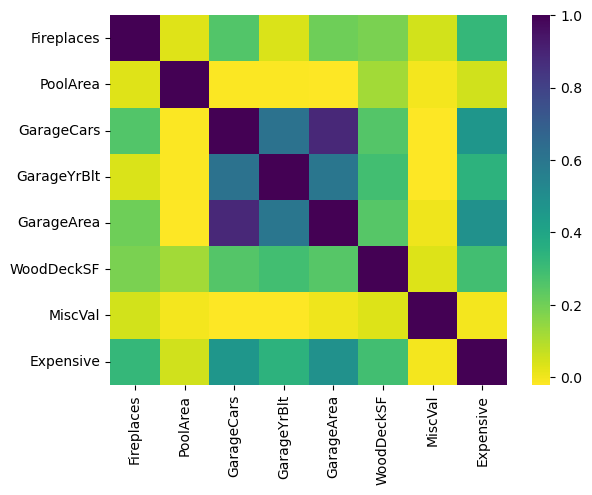

In [37]:
corr_extra_df = correlation(extra)

sns.heatmap(corr_extra_df,
            cmap="viridis_r",
           );

In [38]:
X_train.loc[:,[
            "FireplaceQu",
            "GarageType",
            "GarageFinish" , #Interior finish of the garage
            "GarageQual" ,    
            "GarageCond"   ,  
            "PavedDrive"   ,
            "PoolQC"    ,     
            "Fence", #Fence quality
            "MiscFeature"]]    #Miscellaneous feature not covered in other categories

,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature
572,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN
290,Gd,Attchd,RFn,Gd,TA,Y,NaN,NaN,NaN
660,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN
993,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN
282,Gd,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
664,Ex,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN
140,Po,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN
466,Po,Attchd,Unf,TA,TA,Y,NaN,GdWo,NaN
79,NaN,Detchd,Unf,TA,TA,Y,NaN,MnPrv,NaN


<Axes: xlabel='MiscFeature', ylabel='Count'>

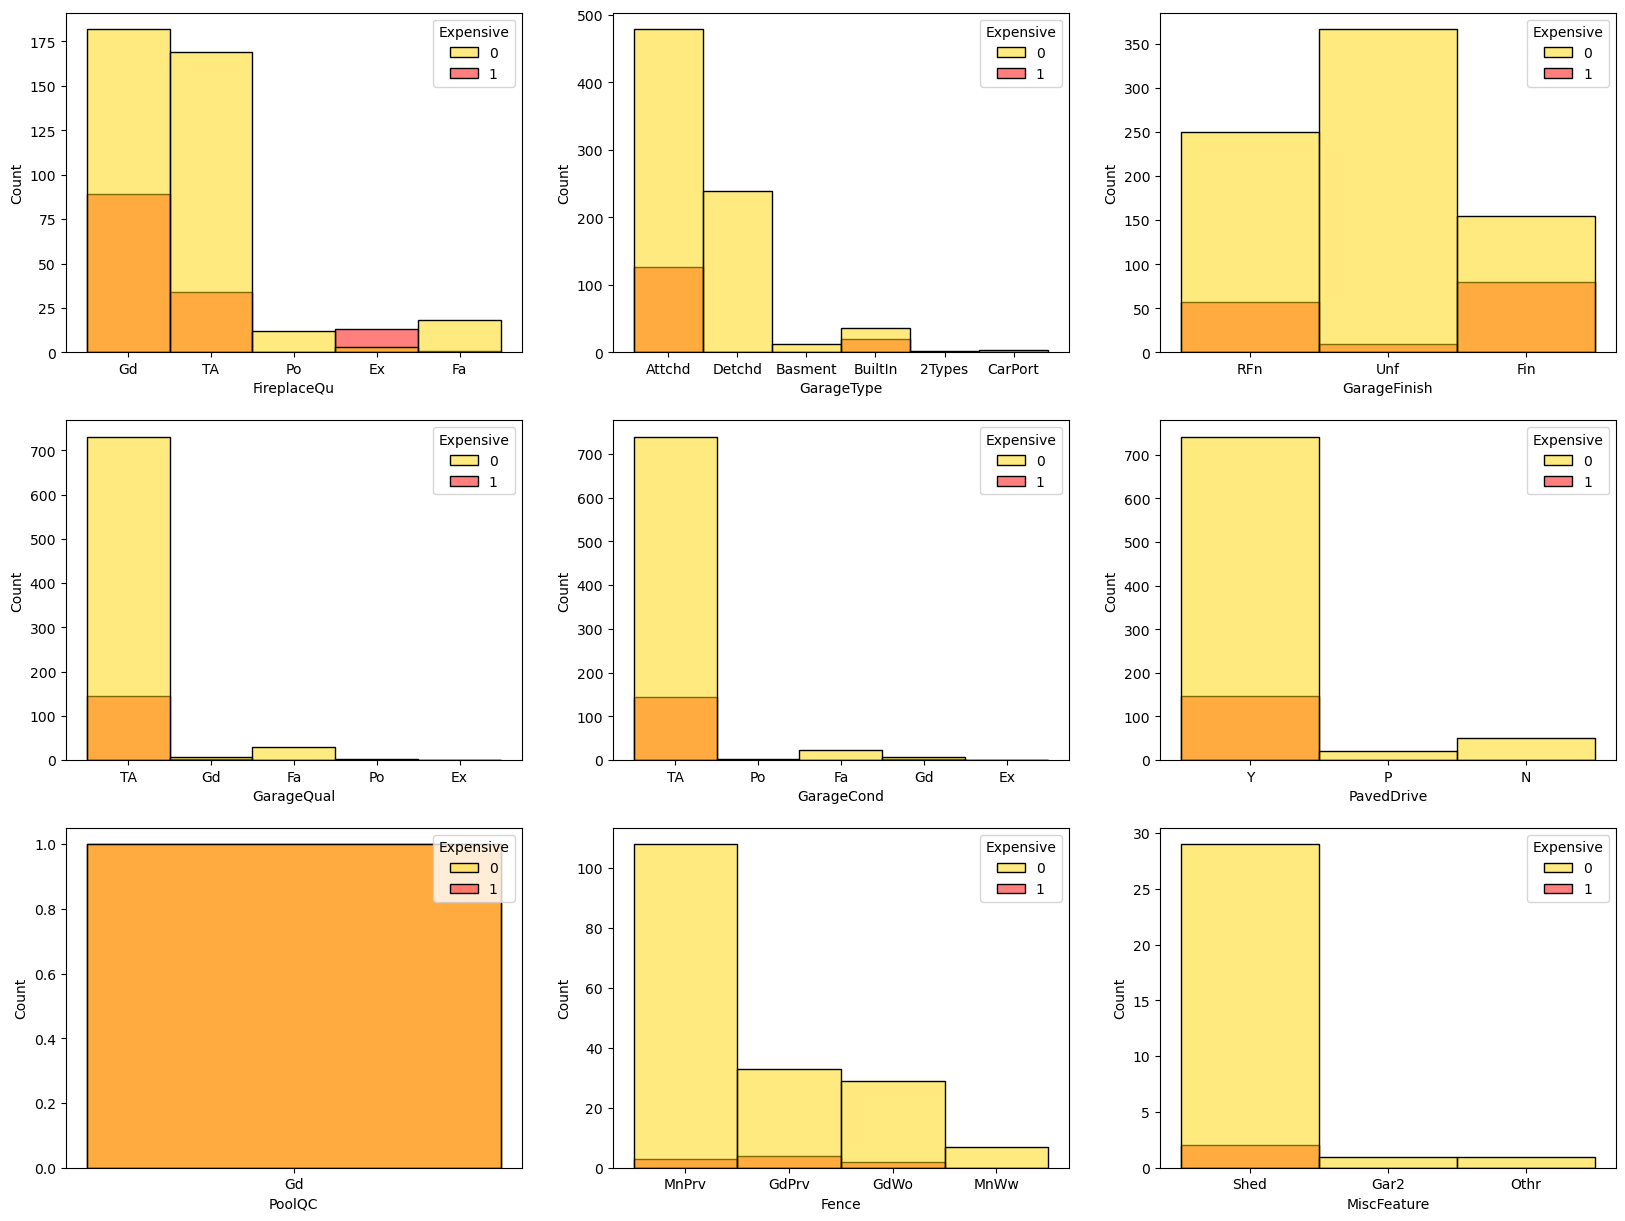

In [39]:
# Extras 
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8)) = plt.subplots(nrows=3, ncols=3, sharex=False,
                                                            figsize=(20, 15))

sns.histplot(data = X_train, x = "FireplaceQu", hue="Expensive",palette=["gold","red"], ax=ax0)
sns.histplot(data = X_train, x =   "GarageType",hue="Expensive",palette=["gold","red"], ax=ax1)
sns.histplot(data = X_train, x = "GarageFinish" , hue="Expensive",palette=["gold","red"], ax=ax2)

sns.histplot(data = X_train, x = "GarageQual", hue="Expensive",palette=["gold","red"], ax=ax3)
sns.histplot(data = X_train, x = "GarageCond",hue="Expensive",palette=["gold","red"], ax=ax4)
sns.histplot(data = X_train, x = "PavedDrive",hue="Expensive",palette=["gold","red"], ax=ax5)

sns.histplot(data = X_train, x = "PoolQC", hue="Expensive",palette=["gold","red"], ax=ax6)
sns.histplot(data = X_train, x = "Fence" , hue="Expensive",palette=["gold","red"], ax=ax7)
sns.histplot(data = X_train, x =  "MiscFeature", hue="Expensive",palette=["gold","red"], ax=ax8)


In [40]:
# Living Quality 
X_train.loc[:,[
            "Heating",
            "Utilities", #Type of utilities available
            "CentralAir",
            "KitchenQual",
            "HeatingQC"   ,
            "Electrical"  ,
            "Functional", #Home functionality (Assume typical unless deductions
            ]]

,Heating,Utilities,CentralAir,KitchenQual,HeatingQC,Electrical,Functional
572,GasA,AllPub,Y,Gd,Gd,SBrkr,Typ
290,GasA,AllPub,Y,Gd,Ex,SBrkr,Typ
660,GasA,AllPub,Y,TA,TA,SBrkr,Typ
993,GasA,AllPub,Y,Gd,Ex,SBrkr,Typ
282,GasA,AllPub,Y,Gd,Ex,SBrkr,Typ
...,...,...,...,...,...,...,...
664,GasA,AllPub,Y,Ex,Ex,SBrkr,Typ
140,GasA,AllPub,Y,TA,TA,SBrkr,Typ
466,GasA,AllPub,Y,TA,TA,SBrkr,Typ
79,GasA,AllPub,Y,TA,Gd,SBrkr,Typ


<Axes: xlabel='MiscFeature', ylabel='Count'>

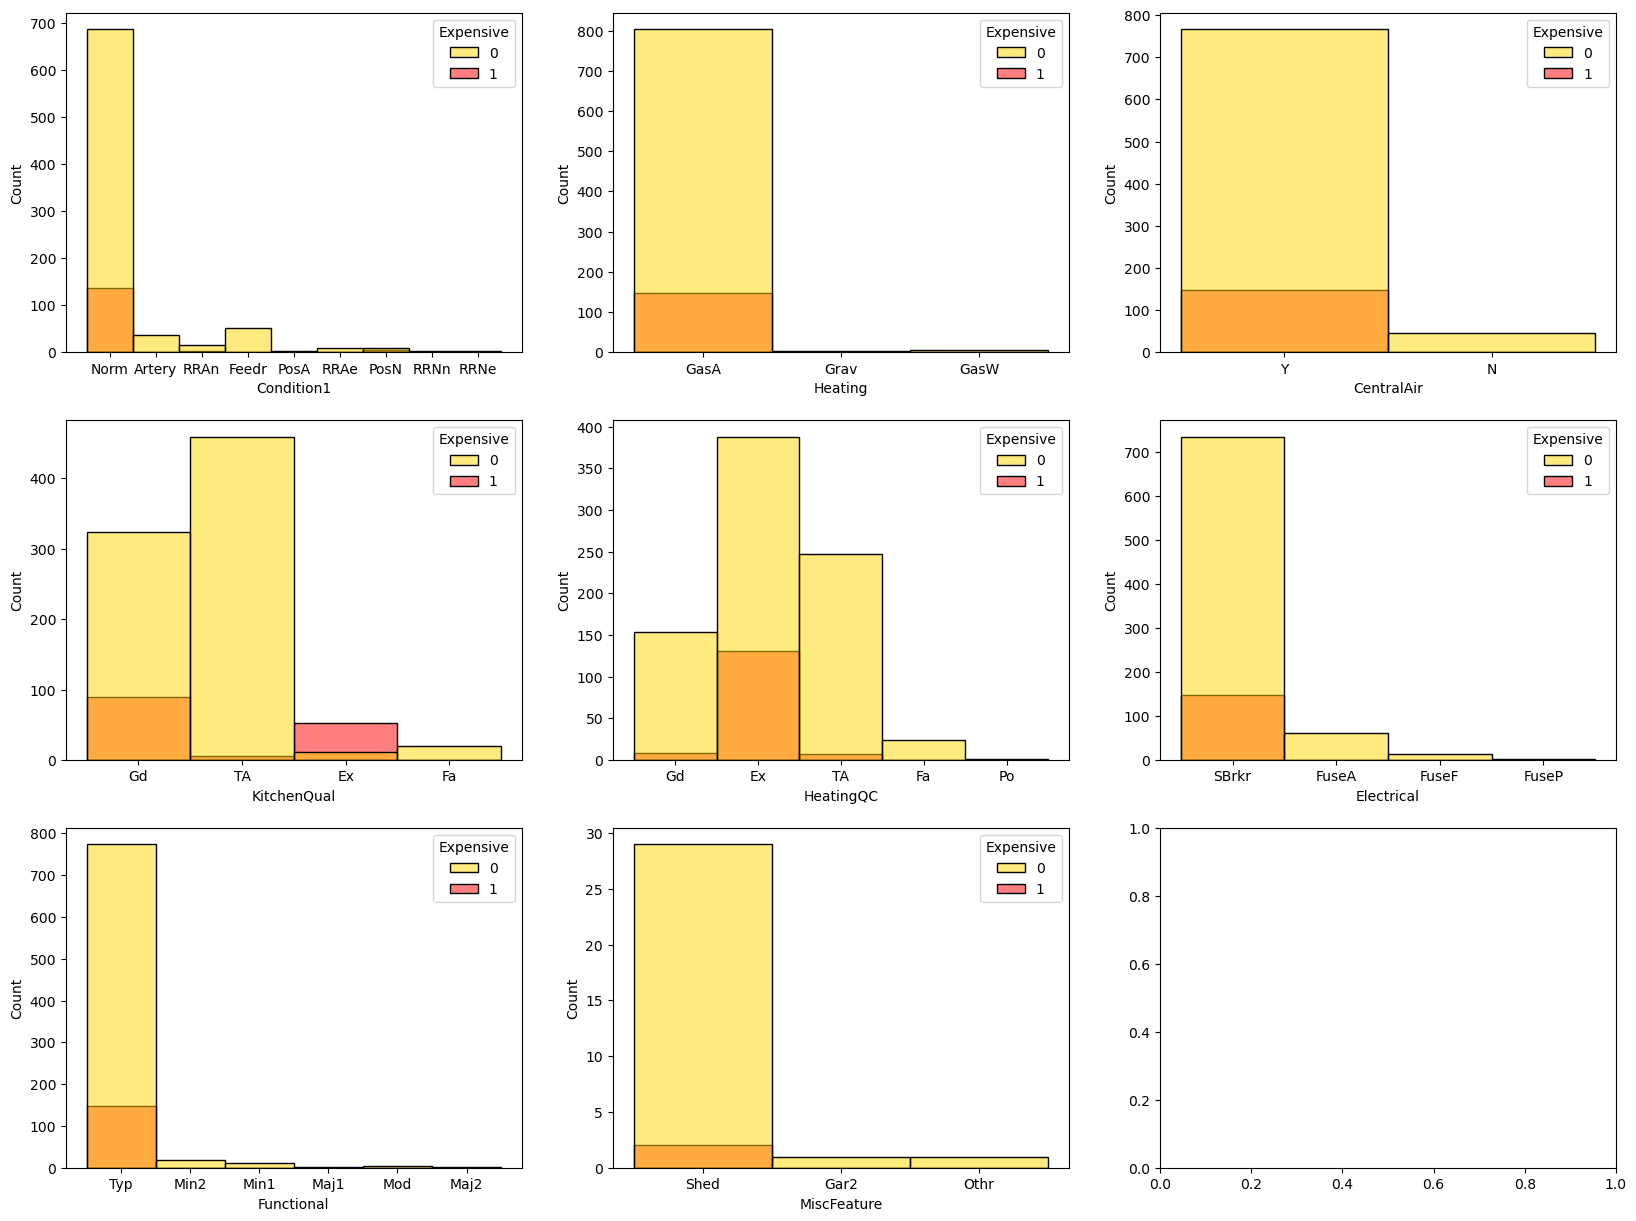

In [41]:
# Extras 
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8)) = plt.subplots(nrows=3, ncols=3, sharex=False,
                                                            figsize=(20, 15))

sns.histplot(data = X_train, x = "Condition1", hue="Expensive",palette=["gold","red"], ax=ax0)
sns.histplot(data = X_train, x =   "Heating",hue="Expensive",palette=["gold","red"], ax=ax1)
sns.histplot(data = X_train, x = "CentralAir" , hue="Expensive",palette=["gold","red"], ax=ax2)

sns.histplot(data = X_train, x = "KitchenQual", hue="Expensive",palette=["gold","red"], ax=ax3)
sns.histplot(data = X_train, x = "HeatingQC",hue="Expensive",palette=["gold","red"], ax=ax4)
sns.histplot(data = X_train, x = "Electrical",hue="Expensive",palette=["gold","red"], ax=ax5)

sns.histplot(data = X_train, x = "Functional", hue="Expensive",palette=["gold","red"], ax=ax6)
sns.histplot(data = X_train, x = "MiscFeature" , hue="Expensive",palette=["gold","red"], ax=ax7)
#sns.histplot(data = X_train, x =  "MiscFeature", hue="Expensive",palette=["gold","red"], ax=ax8)


In [42]:
# Building Quality
build = X_train.loc[:,[
            "MasVnrArea", #Masonry veneer area in square feet
            "OverallQual"    ,
            "OverallCond"      ,
            "YearBuilt"     ,
            "YearRemodAdd"   , #Remodel date
            "LowQualFinSF",
            "Expensive", ]]

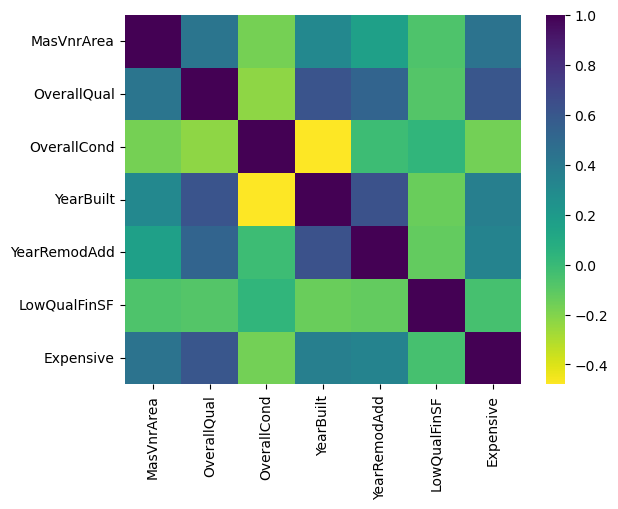

In [43]:
corr_build_df = correlation(build)

sns.heatmap(corr_build_df,
            cmap="viridis_r",
           );

In [44]:
# Building Quality
X_train.loc[:,["Foundation"   ,  
            "ExterQual",
            "ExterCond",
            "RoofStyle"     , 
            "RoofMatl"     ,
            "Exterior1st", #Exterior covering on house
            "Exterior2nd" , ]]

,Foundation,ExterQual,ExterCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd
572,PConc,TA,TA,Gable,CompShg,VinylSd,VinylSd
290,PConc,Gd,TA,Gable,CompShg,VinylSd,VinylSd
660,CBlock,TA,TA,Gable,CompShg,Plywood,Plywood
993,PConc,TA,TA,Gable,CompShg,VinylSd,VinylSd
282,PConc,Gd,TA,Gable,CompShg,VinylSd,VinylSd
...,...,...,...,...,...,...,...
664,PConc,Gd,TA,Gable,CompShg,VinylSd,VinylSd
140,CBlock,TA,TA,Gable,CompShg,HdBoard,HdBoard
466,CBlock,TA,Gd,Flat,Tar&Grv,Plywood,Plywood
79,PConc,TA,TA,Gable,CompShg,Wd Sdng,Wd Sdng


<Axes: xlabel='Exterior2nd', ylabel='Count'>

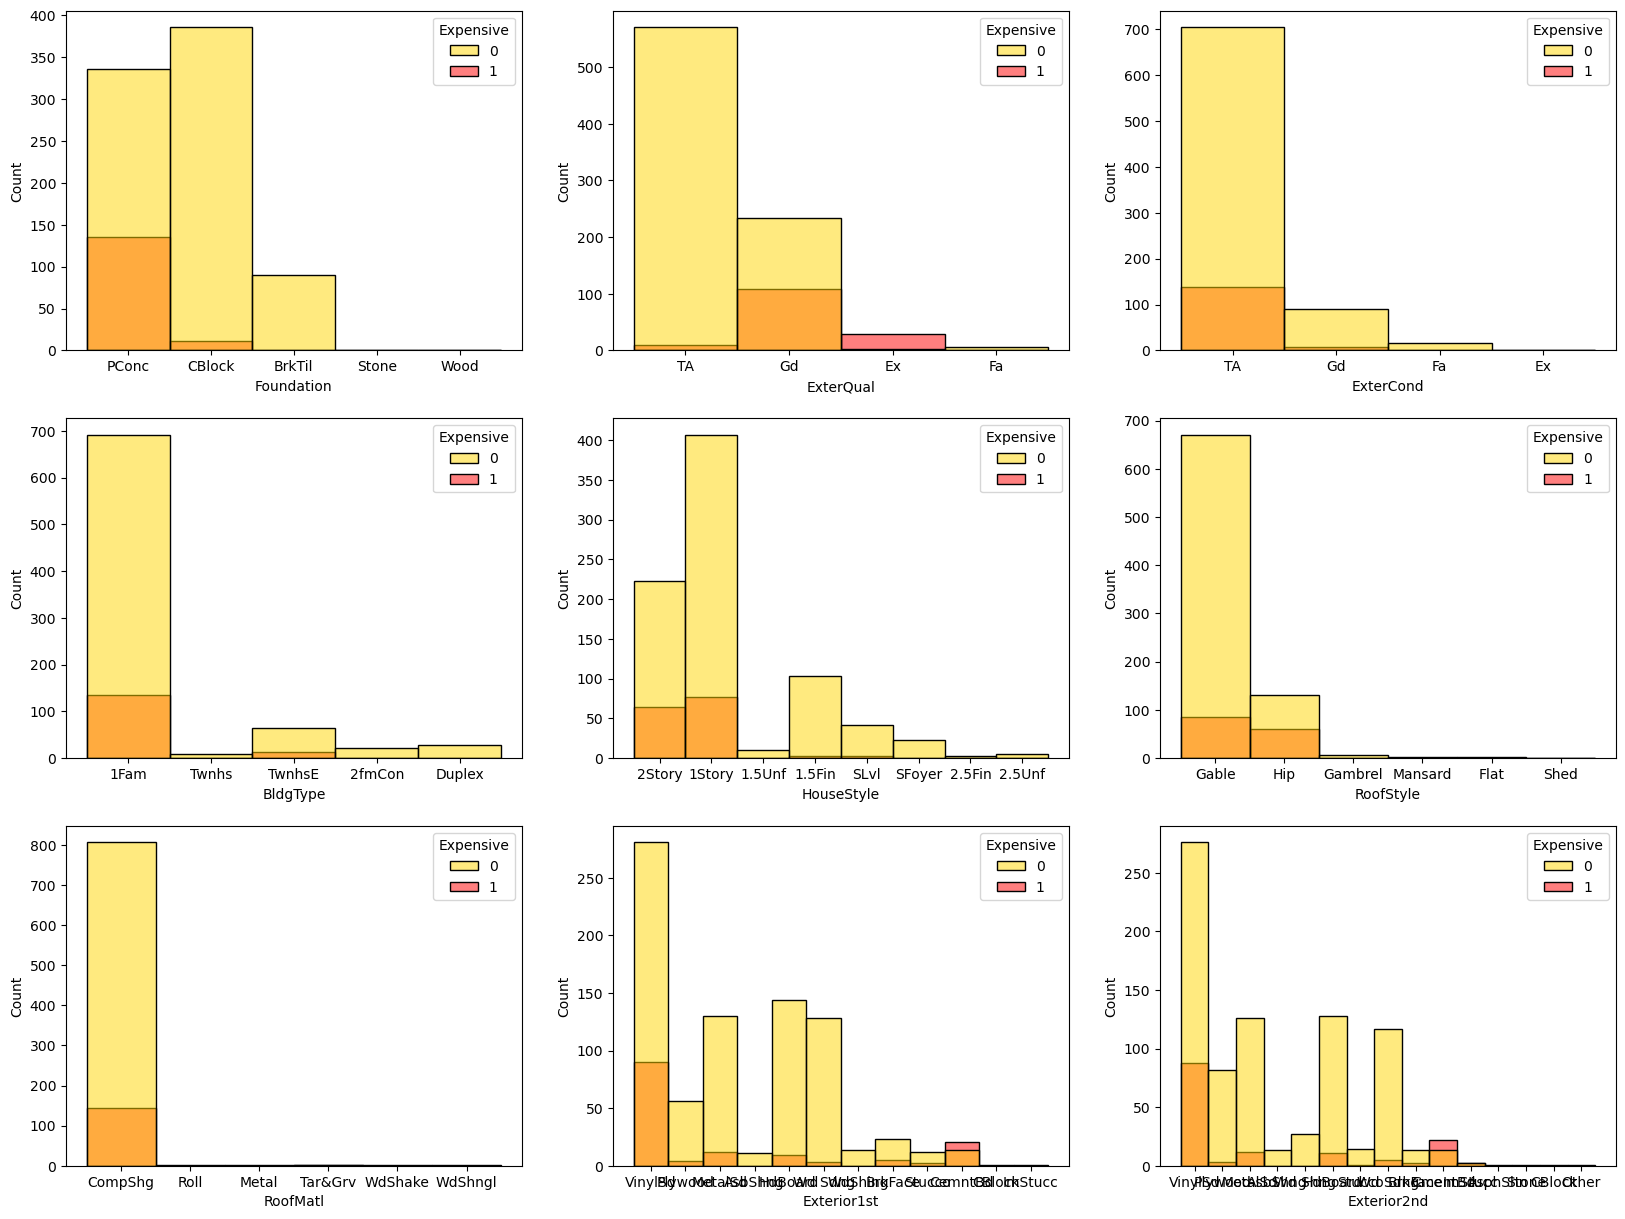

In [45]:
# Extras 
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8)) = plt.subplots(nrows=3, ncols=3, sharex=False,
                                                            figsize=(20, 15))

sns.histplot(data = X_train, x = "Foundation", hue="Expensive",palette=["gold","red"], ax=ax0)
sns.histplot(data = X_train, x =   "ExterQual",hue="Expensive",palette=["gold","red"], ax=ax1)
sns.histplot(data = X_train, x = "ExterCond" , hue="Expensive",palette=["gold","red"], ax=ax2)

sns.histplot(data = X_train, x = "BldgType", hue="Expensive",palette=["gold","red"], ax=ax3)
sns.histplot(data = X_train, x = "HouseStyle",hue="Expensive",palette=["gold","red"], ax=ax4)
sns.histplot(data = X_train, x = "RoofStyle",hue="Expensive",palette=["gold","red"], ax=ax5)

sns.histplot(data = X_train, x = "RoofMatl", hue="Expensive",palette=["gold","red"], ax=ax6)
sns.histplot(data = X_train, x = "Exterior1st" , hue="Expensive",palette=["gold","red"], ax=ax7)
sns.histplot(data = X_train, x =  "Exterior2nd", hue="Expensive",palette=["gold","red"], ax=ax8)


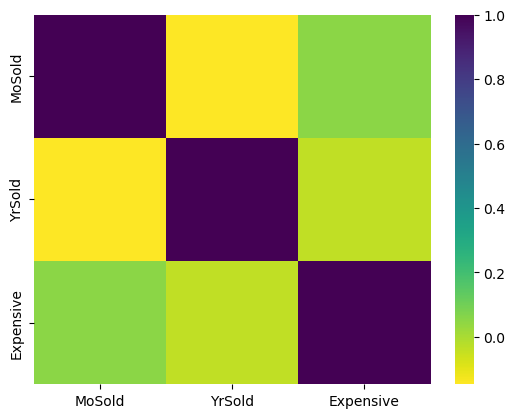

In [46]:
sale = X_train.loc[:,[   
"MoSold" ,   
"YrSold"   ,
"Expensive"]]
corr_sale_df = correlation(sale)

sns.heatmap(corr_sale_df,
            cmap="viridis_r",
           );

In [47]:
# Sale Data
X_train.loc[:,[   
"MoSold" ,   
"YrSold"   ,
"SaleType",
"SaleCondition"]]

,MoSold,YrSold,SaleType,SaleCondition
572,7,2009,New,Partial
290,7,2006,New,Partial
660,11,2007,WD,Normal
993,8,2006,New,Partial
282,4,2009,ConLw,Normal
...,...,...,...,...
664,1,2006,New,Partial
140,4,2010,ConLI,Normal
466,4,2007,WD,Normal
79,5,2009,WD,Normal


<Axes: xlabel='SaleCondition', ylabel='Count'>

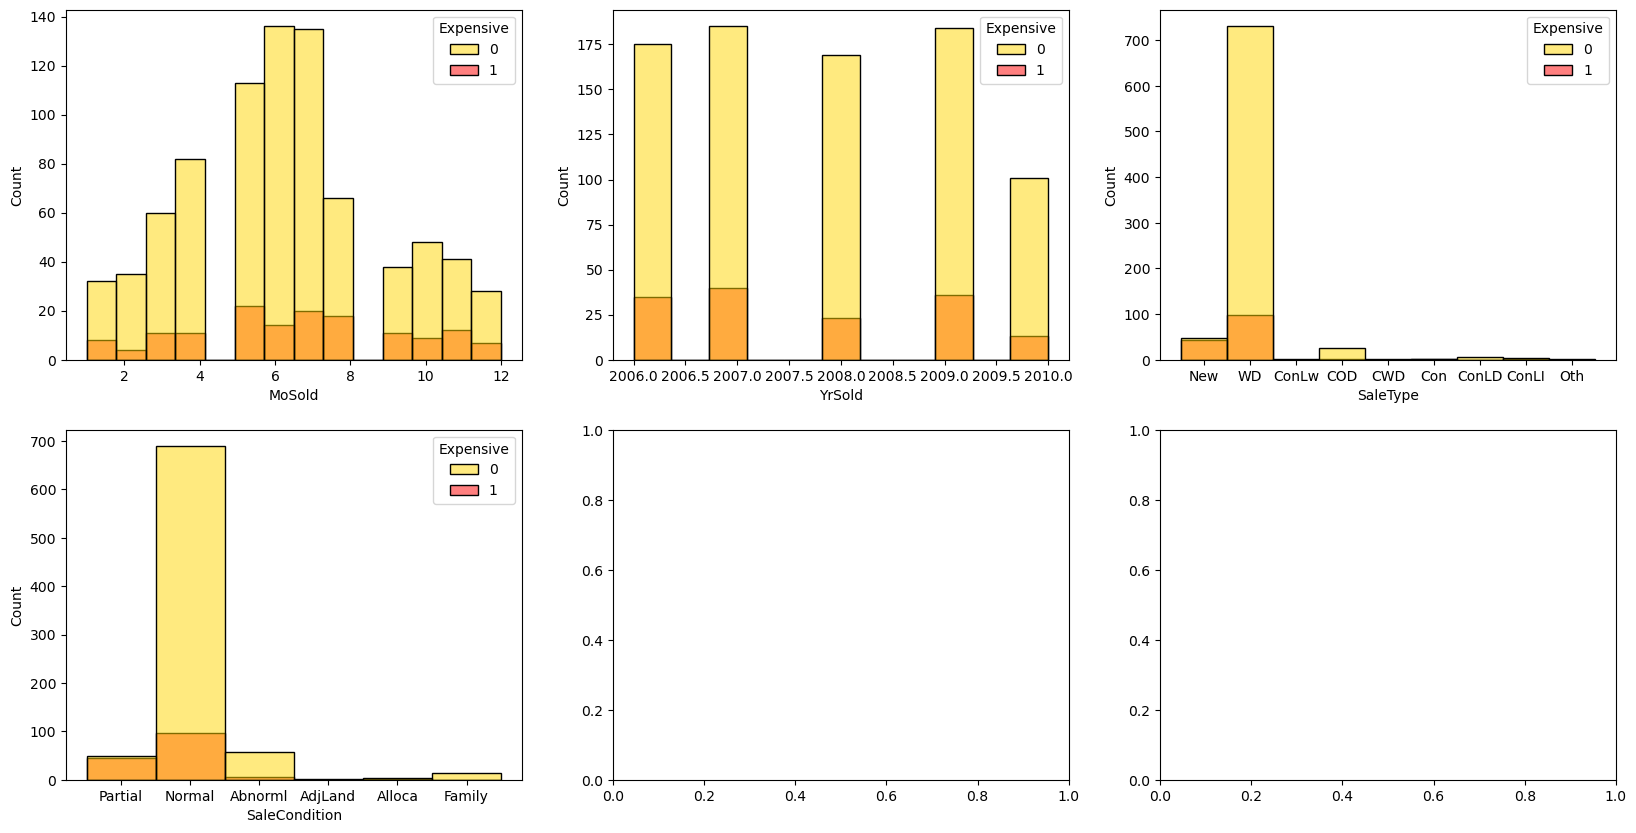

In [48]:
# Extras 
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(nrows=2, ncols=3, sharex=False,
                                                            figsize=(20, 10))

sns.histplot(data = X_train, x = "MoSold", hue="Expensive",palette=["gold","red"], ax=ax0)
sns.histplot(data = X_train, x =   "YrSold",hue="Expensive",palette=["gold","red"], ax=ax1)
sns.histplot(data = X_train, x = "SaleType" , hue="Expensive",palette=["gold","red"], ax=ax2)

sns.histplot(data = X_train, x = "SaleCondition", hue="Expensive",palette=["gold","red"], ax=ax3)


In [53]:
y_train = X_train.pop("Expensive")

## Iteration 0 - Intuitive Model

**Absolute Baseline with all houses inexpensive**

In [57]:
pred_nonexpensive = pd.Series(0, index = X_train.index)
accuracy_score(y_true=y_train,y_pred = pred_nonexpensive)

0.8470343392299687